In [1]:
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
import scipy as sp
from captum.attr import LayerIntegratedGradients
from bertviz import model_view

warnings.filterwarnings("ignore")

In [2]:
# =============================================================================
# 2. Loading and Exploring the Dataset
# =============================================================================
df = pd.read_csv("final_data.csv")
df = df[["text", "og_label", "LABEL"]]
df = df.rename(columns={"text": "phrase", "LABEL": "label"})
print("Initial data shape:", df.shape)

# droping any missing labels
df = df.drop("og_label", axis=1).dropna(subset=["label"]).reset_index(drop=True)
print("After dropping missing labels:", df.shape)

df

Initial data shape: (2306, 3)
After dropping missing labels: (1967, 2)


,phrase,label
0,When I remember her I feel down,Neurological & General Symptoms
1,When I carry heavy things I feel like breaking...,Dermatological & Skin Conditions
2,there is too much pain when i move my arm,Chronic Conditions
3,My son had his lip pierced and it is swollen a...,Infections
4,My muscles in my lower back are aching,Infections
...,...,...
1962,"Severe abdominal or back pain, blood in urine,...",Pain & Injuries
1963,"Fragile bones, loss of height over time, back ...",Chronic Conditions
1964,"Joint pain, stiffness, swelling, fatigue, loss...",Chronic Conditions
1965,"Frequent urination, Increased thirst, Weight loss",Chronic Conditions


In [3]:
# =============================================================================
# 3. Preprocessing the Dataset
# =============================================================================
# Building label
unique_labels = sorted(df["label"].unique().tolist())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
print("Label mapping:", label2id)

# Maping numeric IDs to human-readable names
label_names = {
    0: "Neurological & General",
    1: "Dermatology",
    2: "Chronic",
    3: "Infection",
    4: "Pain/Injury",
    5: "GI/Hepato",
    6: "Respiratory/Sensory",
    7: "Allergy/Immunology",
}

df["label_id"] = df["label"].map(label2id)

# Spliting into train/val/test
train_df_og, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df_og, test_size=0.20, random_state=42)

# Converting to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["phrase", "label_id"]])
val_dataset = Dataset.from_pandas(val_df[["phrase", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["phrase", "label_id"]])

Label mapping: {'Allergic/Immunologic Reactions': 0, 'Chronic Conditions': 1, 'Dermatological & Skin Conditions': 2, 'Gastrointestinal & Hepatobiliary Conditions': 3, 'Infections': 4, 'Neurological & General Symptoms': 5, 'Pain & Injuries': 6, 'Respiratory & Sensory Issues': 7}


In [4]:
# =============================================================================
# 4. Tokenizing the Text Data for BERT-base
# =============================================================================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(
        examples["phrase"], padding="max_length", truncation=True, max_length=128
    )


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1258 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

In [5]:
# =============================================================================
# 5. Renaming & Formating for Trainer
# =============================================================================
train_dataset = train_dataset.rename_column("label_id", "labels")
val_dataset = val_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [8]:
# =============================================================================
# 6. Defining the BERT Model and Training
# =============================================================================
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)
model.config.output_attentions = True

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Training the model
trainer.train()

# Evaluating on validation and test sets
print("Validation metrics:", trainer.evaluate(eval_dataset=val_dataset))
print("Test metrics:      ", trainer.evaluate(eval_dataset=test_dataset))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.828700,0.647229,0.806349,0.799362
2,0.348300,0.455950,0.876190,0.875783
3,0.103400,0.498279,0.888889,0.889040
4,0.056100,0.429199,0.904762,0.904323
5,0.018700,0.465079,0.895238,0.895234


Validation metrics: {'eval_loss': 0.4650788903236389, 'eval_accuracy': 0.8952380952380953, 'eval_f1': 0.8952338488787601, 'eval_runtime': 4.287, 'eval_samples_per_second': 73.479, 'eval_steps_per_second': 9.331, 'epoch': 5.0}
Test metrics:       {'eval_loss': 0.3494935929775238, 'eval_accuracy': 0.9111675126903553, 'eval_f1': 0.9111309009321563, 'eval_runtime': 11.7822, 'eval_samples_per_second': 33.44, 'eval_steps_per_second': 4.244, 'epoch': 5.0}


,precision,recall,f1-score,support
Neurological & General,0.7333,1.0000,0.8462,11
Dermatology,0.8644,0.9444,0.9027,54
Chronic,0.9167,0.9016,0.9091,61
Infection,0.8889,0.9231,0.9057,26
Pain/Injury,0.9298,0.8833,0.9060,60
GI/Hepato,0.9000,0.7826,0.8372,23
Respiratory/Sensory,0.8889,0.8511,0.8696,47
Allergy/Immunology,0.9375,0.9091,0.9231,33
accuracy,0.8952,0.8952,0.8952,0.8952
macro avg,0.8824,0.8994,0.8874,315


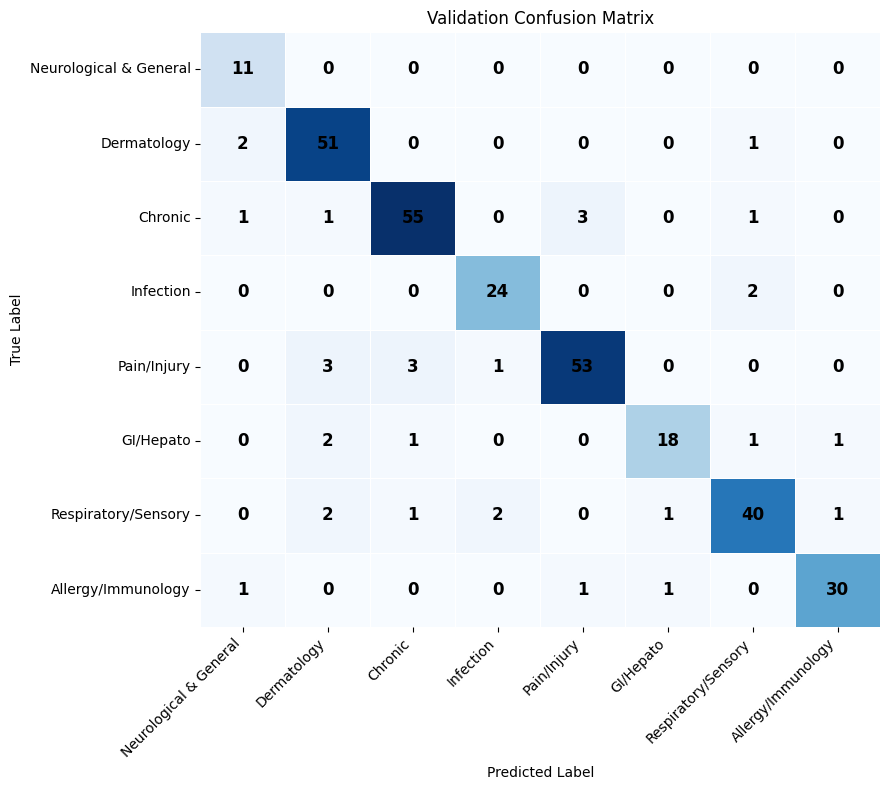

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

In [ ]:
# -----------------------------------------------------------------------------
# Full evaluation script: Per-class validation report (white + blue support) + confusion matrix
# -----------------------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

# 1) Get predictions from the HuggingFace Trainer
preds_output = trainer.predict(val_dataset)
y_true = preds_output.label_ids
preds = preds_output.predictions
logits = preds[0] if isinstance(preds, tuple) else preds
y_pred = np.argmax(logits, axis=-1)

# 2) Build the list of class names in sorted order
target_names = [label_names[i] for i in sorted(label_names)]

# 3) Generate the classification report as a DataFrame
report_dict = classification_report(
    y_true, y_pred, target_names=target_names, digits=4, output_dict=True
)
df_report = pd.DataFrame(report_dict).transpose()

# 4) Reorder rows: each class, then accuracy, macro avg, weighted avg
desired_order = target_names + ["accuracy", "macro avg", "weighted avg"]
df_report = df_report.loc[desired_order]

# 5) Style & display the per-class report as “Table 1”
idx = pd.IndexSlice
styled = (
    df_report.style
    # white background, black bold text for all cells
    .set_properties(
        **{"background-color": "white", "color": "black", "font-weight": "bold"}
    )
    # blue gradient on the support column only
    .background_gradient(cmap="Blues", subset=["support"], low=0, high=0.8)
    # numeric formatting
    .format({"precision": "{:.4f}", "recall": "{:.4f}", "f1-score": "{:.4f}"})
    .format(
        "{:.0f}",  # integer support for classes & avgs
        subset=idx[df_report.index != "accuracy", "support"],
    )
    .format("{:.4f}", subset=idx[["accuracy"], "support"])  # accuracy support as float
    # make the table full width
    .set_table_attributes('style="width:100%; border-collapse: collapse;"')
)

# Display caption and styled table
display(HTML("<h3>Table 1: Per-class validation report</h3>"))
display(styled)


# 6) Compute & plot raw-count confusion matrix
cm = confusion_matrix(y_true, y_pred)
short_labels = [
    "Neurological & General",
    "Dermatology",
    "Chronic",
    "Infection",
    "Pain/Injury",
    "GI/Hepato",
    "Respiratory/Sensory",
    "Allergy/Immunology",
]

plt.figure(figsize=(9, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=short_labels,
    yticklabels=short_labels,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"color": "black", "weight": "bold", "fontsize": 12},
)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 7) Save fine-tuned model & tokenizer for later use
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

In [10]:
# =============================================================================
# 7. Loading the fine-tuned model & Inference Pipeline
# =============================================================================
inference_model = BertForSequenceClassification.from_pretrained("my_model")
inference_tokenizer = BertTokenizer.from_pretrained("my_model")
inference_model.config.output_attentions = True

classifier = pipeline(
    task="text-classification", model=inference_model, tokenizer=inference_tokenizer
)

# real-world examples
for text in [
    "Sometimes i feel heart pain",
    "The weather is filthy; I can't breathe properly",
]:
    print(f"Text: {text}\nPrediction: {classifier(text)[0]}\n")

Device set to use mps:0


Text: Sometimes i feel heart pain
Prediction: {'label': 'Chronic Conditions', 'score': 0.9968639612197876}

Text: The weather is filthy; I can't breathe properly
Prediction: {'label': 'Respiratory & Sensory Issues', 'score': 0.9978875517845154}



In [11]:
# =============================================================================
# 8. BertViz Visualization of Model Attention
# =============================================================================
sample_text = "i feel pain in my knee"
inputs = inference_tokenizer.encode(sample_text, return_tensors="pt").to(
    inference_model.device
)
outputs = inference_model(inputs)
attention = outputs.attentions
tokens = inference_tokenizer.convert_ids_to_tokens(inputs[0].cpu())
model_view(attention, tokens)

<IPython.core.display.Javascript object>

Extracted embeddings shape: (394, 768)


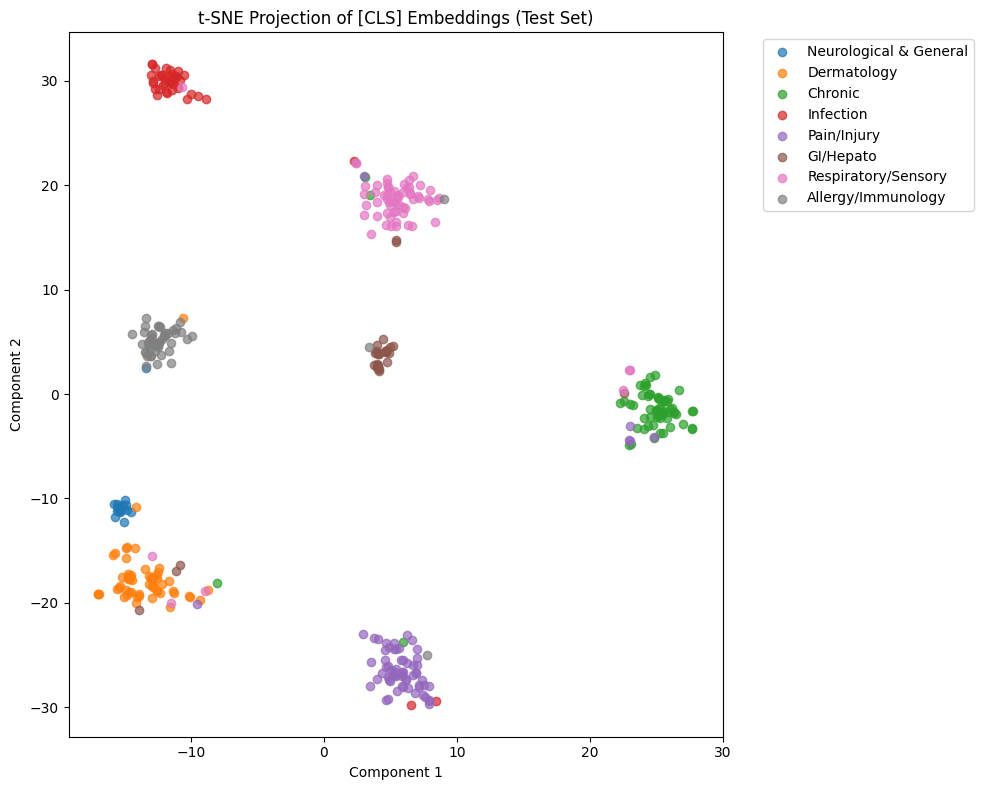

In [12]:
# =============================================================================
# 9. Embedding Analysis & Interpretation
# =============================================================================
inference_model.config.output_hidden_states = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_model.to(device)


def get_cls_embedding(batch):
    inputs = {
        "input_ids": batch["input_ids"].to(device),
        "attention_mask": batch["attention_mask"].to(device),
    }
    with torch.no_grad():
        out = inference_model(**inputs)
    return out.hidden_states[-1][:, 0, :].cpu().numpy()


all_embeddings, all_labels = [], []
batch_size = 8

for i in range(0, len(test_dataset), batch_size):
    batch = test_dataset[i : i + batch_size]
    embs = get_cls_embedding(batch)
    all_embeddings.append(embs)
    all_labels.extend(batch["labels"].numpy())

all_embeddings = np.vstack(all_embeddings)
print("Extracted embeddings shape:", all_embeddings.shape)

# runing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(all_embeddings)

# updating plot with label names
plt.figure(figsize=(10, 8))
for label_id, name in label_names.items():
    idxs = np.where(np.array(all_labels) == label_id)
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], alpha=0.7, label=name)

plt.title("t-SNE Projection of [CLS] Embeddings (Test Set)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

PartitionExplainer explainer: 101it [05:45,  3.52s/it]                         


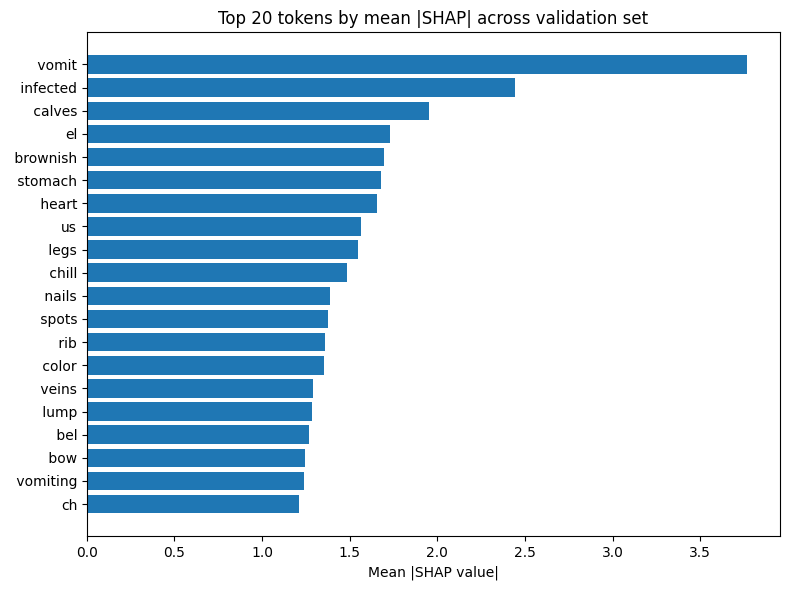

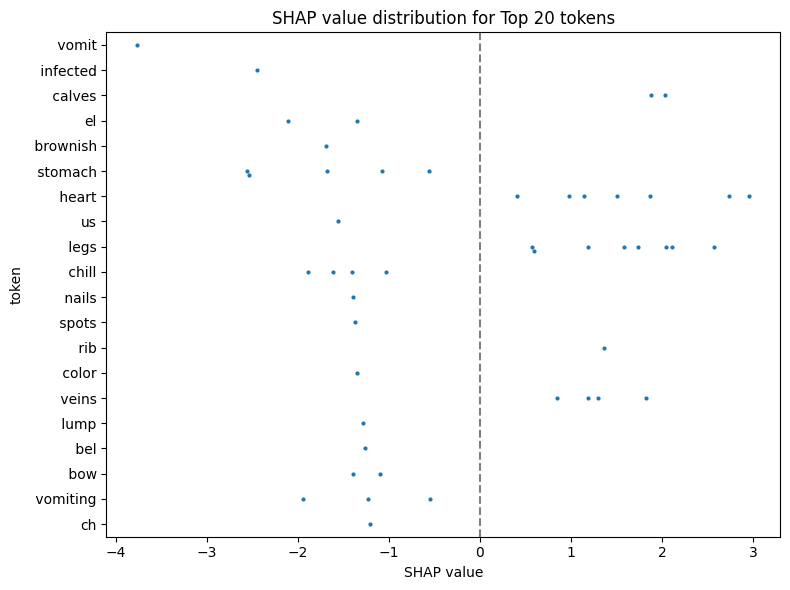

In [ ]:
# =============================================================================
# 10. SHAP Explainer for Model Predictions (dataset‐level, broadcast‐safe)
# =============================================================================
import shap
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

# Making sure your fine-tuned model is on the right device
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda")
)
inference_model.to(device)


# Defining the SHAP forward function (returns log-odds for class 1)
def shap_forward(texts):
    toks = [
        inference_tokenizer.encode(
            t, padding="max_length", truncation=True, max_length=128
        )
        for t in texts
    ]
    tv = torch.tensor(toks).to(device)
    logits = inference_model(tv)[0].detach().cpu().numpy()
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    return sp.special.logit(probs[:, 1])


# Wraping tokenizer in a Text masker
masker = shap.maskers.Text(inference_tokenizer)
explainer = shap.Explainer(shap_forward, masker)

# ──────────────────────────────────────────────────────────────────────────────
# Computing SHAP values for a batch of phrases**
# ──────────────────────────────────────────────────────────────────────────────
texts = val_df["phrase"].tolist()[:100]
shap_vals = explainer(texts)

# Building a map token → list of all its SHAP values
tok2vals = defaultdict(list)
for vals, toks in zip(shap_vals.values, shap_vals.data):
    for v, t in zip(vals, toks):
        tok2vals[t].append(v)

# Computing mean absolute SHAP per token
mean_abs = {t: np.mean(np.abs(vs)) for t, vs in tok2vals.items()}

# Selecting top-20 tokens by mean(|SHAP|)
top20 = sorted(mean_abs.items(), key=lambda kv: kv[1], reverse=True)[:20]
tokens, scores = zip(*top20)

# Horizontal bar chart of mean |SHAP|
plt.figure(figsize=(8, 6))
plt.barh(tokens[::-1], scores[::-1])
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 tokens by mean |SHAP| across validation set")
plt.tight_layout()
plt.show()

# Building DataFrame for beeswarm
import pandas as pd

rows = []
for t in tokens:
    for v in tok2vals[t]:
        rows.append((t, v))
bee_df = pd.DataFrame(rows, columns=["token", "shap_value"])

# Beeswarm plot
plt.figure(figsize=(8, 6))
sns.swarmplot(x="shap_value", y="token", data=bee_df, orient="h", size=3)
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("SHAP value")
plt.title("SHAP value distribution for Top 20 tokens")
plt.tight_layout()
plt.show()